<div style="text-align: right">INFO 7610 Special Topics in NLP, Lecture 6 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 16 June 2022, with material from the torch and tensorflow people, and Jay Alammar</div>

# The Transformer Architecture for Tensorflow 2.x

<br />
<left>
<img src="ipynb.images/bumble-bee.jpg" width=300 />
</left>
With recurrent neural networks, you input a tensor and you get a matrix out.

In a **dense** (fully connected) neural network, you have one output per input. You have an image and you have a label, for instance. There is no way you can input image after image on Neural Networks and get an output based on all of them. The nature of dense neural networks make them unable to process **sequential data**.

On the other hand, RNNs work very well with sequential data. They have a mechanism for **remembering** the previous inputs and producing an output based on all of the inputs. This makes them well-suited for sequential type of data such as text, audio, video or any time-series data.

However, owing to their iterative nature, it takes quite a long time for information to propagate (linear in the length of the sequence) through RNNs, making it difficult to exploit the merits of concurrent hardware such as GPUs. 

CNNs are immune to this problem as each kernel application is performed in isolation (within the same layer). Unfortunately this comes at the cost of only being able to account for fixed-sized contexts. 

Dense fully-connected layers do not account for sequential information and have yet to prove their suitability for these tasks.

Released in late 2017, [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) is the 3rd big revolution in deep learning community and is now considered as a go-to method for sequence transduction (NLP) tasks. 

The so-called **Transformer** leverages **fully-connected** networks with an enhanced **attention** mechanism. No more RNNs!

The core idea behind the Transformer model is an expansion of the mechanism of **self-attention** we already studied: 

>**Definition**: Self-attention is the ability to attend to different positions of the input sequence to compute a representation of that sequence. 

Transformer creates **stacks** of ((self-attention layers, ***in both the encoder and decoder***, as well as ***cross-attention between the 2*** (what we called semi-Attention and already studied). That's a lot of Attention!

The Transformer is the first transduction model relying entirely on **Attention** to compute representations of its input and output without using sequence aligned RNNs or CNNs. Read the google [post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) introducing it.

Google says The Transformer model:
- Yields higher translation quality
- Requires less computation to train
- Is a much better fit for modern machine learning hardware, speeding up training by up to an order of magnitude

Let's run experiments to see if that is true!

A transformer model handles variable-sized input using stacks of self-attention layers instead of RNNs or CNNs. Advantages are:

- Layer outputs can be calculated in parallel, instead of in a series like an RNN (even though we batch the sequences)
- Distant items can affect each other's output without passing through many RNN-steps or convolution layers, so it can effectively learn long-range dependencies

Downsides are:

- For a time-series, the output for a time-step is calculated from the **entire history** instead of only the inputs and current hidden-state. This may be less efficient. But google says that's not the case.
- If the input does have a temporal/spatial relationship, as with text, some positional encoding must be added or the model will effectively see a **bag of words**. Transformer does include that.
- It's more complicated than seq2seq with attention!

# 1. s2s with Attention and Transformer Attention

## s2s without Attention
In transducing a sequence $x = (x_1, \ldots, x_T)$ of variable length $T$ into another sequence $y = (y_1, \ldots, y_{T'})$ of length T’, the first sequence $x$ is first consumed by an encoder RNN which yields a final state $h_T$ using the following equation:

$$h_{t+1} = σ (W_E h_t +Q_E x_{t+1} ) ∈ R^{d_H}$$

where $h_0$  is typically zero initialized and $σ()$ denotes some suitable non-linearity. 

A decoder RNN takes the $d_H$ dimensional output $h_T$  of the encoder as an initial condition and produces a variably-sized sequence:

$$g_{t+1} = \sigma(W_D g_{t} + Q_D y_t) \in \mathbb{R}^{d_G}$$
 
$$y_{t+1} = \textrm{softmax}(W_Y g_{t+1}) \in \mathbb{R}^{d_V}$$

where $y_0 = h_T$  and $g_0 = \mathbf{0}$. 

Notice that the last generated output token $y$ is used as an input in the next step. In practice, an end token (`<end>`) often serves as a termination symbol so that the model doesn’t produce sequences of infinite length in prediction mode.

The above model still has one *profound* shortcoming - it needs to ***pack*** all of the information of the input sequence into a single vector $h_T$. Since the input sequences’ lengths are unbounded, we have to put an *unbounded amount of information* into this vector. As the vector’s capacity is bounded, it becomes ***impossible*** for the decoder to produce sensible output sequences of arbitrary length. That's why we had so much difficulty producing good chinese translations with pure s2s.

In other words, the architecture has a major **recency bias**, losing the signal from earlier on in the sentence in favor of “more relevant” recent words. This information, however, is not always more relevant. 

Take for example the sentence: *Inside the safari park, I walked over to pet a tiger*. Though the words *pet* and
*walked over* are far more recent, it is clear that *safari park* is far more important to predicting that you actually went to pet a tiger.

Also, the model is sequential and the output from one RNN layer is the input for the next RNN layer. In other words, we can’t run several computations at the same time since each computation depends on all previous ones. This makes training S-L-O-W.

## s2s with semi-Attention using (key, query, value) analogy
**Attention** [Bahdanau, 2014] rids us of this requirement. Content-based attention mechanisms use the **entirety** of intermediate encoder states $h = (h_1, \ldots, h_T)$ (the so-called **keys**) as a *memory* which can be queried using a so-called **query** vector (usually a decoder *word*).

Attention lets the decoder focus on specific parts of the input sentence for each output word. This helps the input and output sentences to align with one another.

<br />
<left>
<img src="ipynb.images/s2s-decoding.png" width=700 />
</left>

**Attention weights** are derived in the following fashion:

$$α_t =h_t^T q ∈ R$$	

for $t=1,\ldots,T$. Intuitively, these can be interpreted as how *related* certain words are for some given query word $q$. 

Then, another component is defined: So-called **value** vectors $v = (v_1, \ldots, v_T)$ can be conceived as being (possibly) non-linear transformations of $h = (h_1, \ldots, h_T)$. 

For the sake of simplicity, let's assume that $v_t = h_t$  holds for all encoder timesteps.

Putting all together we arrive at the **context vector**:

$$w = ∑_{t=1}^T α_t′ v_t = ∑_{t=1}^T α_k′ h_t  ∈ R^{d_H}$$

where $\alpha_{t}' =\frac{\alpha_{t}}{\sum_{k=1}^T \alpha_{k}}$  is the **normalized attention weight**. In the best case, this context vector (also called a **summary**) $w$ contains salient information which aids us in generating the next symbol by supplying it as an input to the decoder.

Breaking the dependence of relying on a fixed-length vector handoff between encoder and decoder has enabled researchers to improve their models by wide margins. And indeed, our s2s-with-attention translations were much better!


## Transformer Attention
Attention in practice is actually a very simple concept — it’s the idea how much you actually care about every piece of information, and weighing it accordingly in making a decision. The Transformer Neural Network does the same thing — it looks at every piece of information, decides how relevant it actually is to making a decision, and gives it a weight accordingly. Then, it weighs all information proportionally when actually making the decision. 

The type of Attention used in Transformers over just semi-Attention we already studied is unique because it computes Attention ***on itself*** (self-attention): Attention of the source sequence with itself, and then Attention of the target sequence with itself, on top of Attention of the target sequence with the source sequence. Essentially, it’s like a dictionary that constantly asks itself — *I wonder what parts of me would be most useful to whoever uses me to make a prediction*, and then proceeds to highlight those parts based on how important they are.

**Scaled Dot Product Attention** is Self Attention that is computed as follows: each decoder word has a **Query vector** Q and a **Key vector** K. The dot product of these two vectors is called the **Value vector** V (take the dot product of Q and K and scale by an expression, hence the name **Scaled Dot Product**). The decoder uses a **masked** (past-context-reliant) version of this, since it can only look at words it has already decoded throughout the translation process.

>**Note**: We are now *vectorizing* operations that used to be sequential in an RNN: Instead of looking at decoder words one by one, timestep by timestep, we look at all of them at the same time, applying an appropriate mask so that the future does not infect the past.

**Multi-Headed Attention** is a repeated version of Scaled Dot Product Attention, applying Attention onto several copies of the same vector which have been filtered/ transformed in meaningful ways, then aggregating the results.

Position doesn’t matter when actually weighting values as above, and all of them can be computed *simultaneously* over all words. But this is catastrophic when we actually build sentences, as words in a sentence do have a natural order! To solve this problem, we build **positional encodings** at the beginning of our model, so that position is kept track of and we can assemble the sentence in order.

The order we must ensure is that our model takes these encodings into account (as input), yet doesn’t modify them and distort our order completely. For this, we build in **Residual**, or **skip** connections, so that we can both use the information as input for our next computational layer and simultaneously *skip it forward*. This allows our encodings to percolate through the network unmodified, so that all layers obtain sentence encodings that don’t sound like they had been Yoda by spoken (Yes, that was intentional).

The last linear layer stretches our vector back into the dimensions of our input dictionary, each value/word assigned a certain weight with a softmax, assigning probabilities to every value in the vector. Ultimately, we pick the neuron with the highest probability, and that yields the output word.

Once upon a time, someone built a tiny multi-million parameter model named a **Transformer**. The Transformer took in an input of words, **encoded** them, kept track of their position (positional encodings), and then learned which of the given words could be used to predict others using Self Attention. It did this by asking itself a survey of several questions, then aggregated the responses (Multi-Headed, Add + Norm). Once it had a meaningful vector encoding, it fed them into a **decoder**, which kept the unmodified original positional encodings by *skipping them over* (Residual Connections). It then proceeded to learn which parts of the encoder were most important for decoding, and repeated this whole gargantuan process 6 times. Finally, it came up with a giant vector. Since, sadly, no human could understand this vector, it widened it to the size of a dictionary (Linear Layer), calculated the probabilities of each word (Softmax Layer), and then predicted the most likely words at each position one by one. 

The Transformer is a revolutionary architecture in NLP. It has been used widely for top performing modern models, such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pretrained Transformer). Although it is quite
complex, it is an elegant architecture that can be analyzed.

# 2. A miniature and real-life language model pair

We always begin with a miniature language model, so we can peek under the hood to see what transformer does! That is how one can debug ML models.

<br />
<left>
<img src="ipynb.images/double-model.jpg" width=800 />
</left>

We load our de-facto **中文** dataset:

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits

import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

With tf 2.x, I do not need to enable eager execution:

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()

#import os
#os.environ['KERAS_BACKEND'] = 'theano'
#import keras as ks

In [3]:
lines= pd.read_table('data/cmn.txt', names=['eng', 'cmn', 'org'])

In [4]:
lines.eng = lines.eng.apply(lambda x: x.lower())
#lines.cmn = lines.cmn.apply(lambda x: x.lower())

In [5]:
# Remove end of lines periods: The regex is \.$
lines.eng = lines.eng.apply(lambda x: re.sub("\.$", '', x))
lines.cmn = lines.cmn.apply(lambda x: re.sub("\.$", '', x))
lines.cmn = lines.cmn.apply(lambda x: re.sub("。$", '', x))

In [6]:
lines.eng = lines.eng.apply(lambda x: re.sub(r"([!#$%&\()*+,-./:;<=>?@[\\]^_`{|}~])", r" \1 ", x))
lines.cmn = lines.cmn.apply(lambda x: re.sub(r"([!#$%&\()*+,-./:;<=>?@[\\]^_`{|}~])", r" \1 ", x))

In [7]:
remove_digits = str.maketrans('', '', digits)
lines.eng = lines.eng.apply(lambda x: x.translate(remove_digits))
lines.cmn = lines.cmn.apply(lambda x: x.translate(remove_digits))

In [8]:
# Remove quotes, saveguard commas:
lines.eng = lines.eng.apply(lambda x: re.sub("'", '', x))
lines.cmn = lines.cmn.apply(lambda x: re.sub("'", '', x))

In [9]:
lines.eng = lines.eng.apply(lambda x: re.sub('"', '', x))
lines.cmn = lines.cmn.apply(lambda x: re.sub('"', '', x))

In [10]:
lines.eng = lines.eng.apply(lambda x: re.sub(",", ' COMMA', x)) #Note the extra space
lines.cmn = lines.cmn.apply(lambda x: re.sub(",", 'COMMA', x))

In [11]:
lines.eng = lines.eng.apply(lambda x: re.sub(r"([!#$%&\()*+,-./:;<=>?@[\\]^_`{|}~])", r" COMMA", x)) #Note the extra space
lines.cmn = lines.cmn.apply(lambda x: re.sub(r"([!#$%&\()*+,-./:;<=>?@[\\]^_`{|}~])", r"COMMA", x))

In [12]:
import zhon
from zhon import hanzi
lines.cmn = lines.cmn.apply(lambda x: re.sub(r"([" + zhon.hanzi.punctuation + "])", r" COMMA ", x))

In [13]:
lines.cmn = lines.cmn.apply(lambda x: x[:-7] if x[-7:] == ' COMMA ' else x)

In [14]:
lines.drop(['org'], axis=1, inplace=True)
lines = lines.drop_duplicates()

In [15]:
import zhconv
from zhconv import convert
lines.cmn = lines.cmn.apply(lambda x: convert(x , 'zh-cn'))

In [16]:
import jieba
lines.cmn = lines.cmn.apply(lambda x: " ".join(jieba.cut(x, cut_all=False)))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/gc/rb79dw2s4ll3nf9v72b36dtr0000gn/T/jieba.cache
Loading model cost 0.788 seconds.
Prefix dict has been built successfully.


We pick 40 medium-length sentences from the middle of our dataset:

In [17]:
lines[10010:10050]

,eng,cmn
10012,underage drinking is a crime,未满 年龄 饮酒 是 罪行
10013,unfortunately COMMA she is absent,不幸 的 是 COMMA 她 不 在
10014,wait here till he comes back,在 这儿 等到 他 回来 为止
10015,was there anyone in the room?,房间 里 有人 吗
10016,wash your hands before meals,饭前 要 洗手
10017,we are badly in need of food,我们 非常 需要 食物
10018,we ate curry rice last night,我们 昨晚 吃 了 咖喱饭
10019,we can do more than they can,我们 能比 他们 做 得 多
10020,we could see nothing but fog,除了 雾 我 看不见 任何 东西
10021,we could walk there together,我们 可以 一起 走 着 去


In [18]:
def preprocess_sentence(w):
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [19]:
def preprocess_sentence_no_tags(w):
    w = w.strip()

    return w

In [20]:
def create_dataset(start, end):
    sentence_pairs = [[preprocess_sentence_no_tags(l[0]), preprocess_sentence(l[1])] for l in lines[start:end].values]
    return zip(*sentence_pairs)

In Transformer, we add beginning and end of sentence sentinels to *both* languages:

In [21]:
def create_full_dataset():
    #sentence_pairs = [[preprocess_sentence_no_tags(l[0]), preprocess_sentence(l[1])] for l in lines.values]
    sentence_pairs = [[preprocess_sentence(l[0]), preprocess_sentence(l[1])] for l in lines.values]
    return zip(*sentence_pairs)

In [22]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [23]:
def load_dataset(start, end):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(start, end)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [24]:
def load_full_dataset():
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_full_dataset()

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [25]:
en, zh = create_full_dataset()
print(en[-1])
print(zh[-1])

<start> if a person has not had a chance to acquire his target language by the time hes an adult COMMA hes unlikely to be able to reach native speaker level in that language <end>
<start> 如果 一个 人 在 成人 前 没有 机会 习得 目标语言   COMMA   他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 <end>


In [26]:
num_examples_p = 40 #len(lines)
input_tensor_p, target_tensor_p, inp_lang_p, targ_lang_p = load_dataset(10010, 10050)

# Calculate max_length of the target tensors
max_length_targ_p, max_length_inp_p = target_tensor_p.shape[1], input_tensor_p.shape[1]
max_length_targ_p, max_length_inp_p

(13, 8)

In [27]:
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang = load_full_dataset()

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(29, 35)

In [28]:
# Creating training and validation sets using an 90-10 split
input_tensor_train_p, input_tensor_val_p, target_tensor_train_p, target_tensor_val_p = train_test_split(
    input_tensor_p, target_tensor_p, test_size=0.1)

# Show length
print(len(input_tensor_train_p), len(target_tensor_train_p), len(input_tensor_val_p), len(target_tensor_val_p))

36 36 4 4


In [29]:
# Creating training and validation sets using an 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.1)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

19865 19865 2208 2208


In [30]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [31]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[30])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[30])

Input Language; index to word mapping
1 ----> <start>
47 ----> how
126 ----> long
38 ----> can
20 ----> it
33 ----> be
497 ----> kept
77 ----> going
35 ----> with
3111 ----> dollars?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
106 ----> 用
446 ----> 美元
47 ----> 可以
1355 ----> 支持
280 ----> 多久
2 ----> <end>


In [32]:
input_tensor_train_p.shape, target_tensor_train_p.shape

((36, 8), (36, 13))

In [33]:
input_tensor_train.shape, target_tensor_train.shape

((19865, 35), (19865, 29))

We will write a large tf `dataset` as well as a miniature model using our own keras-style generator:

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = len(input_tensor_train)

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset_train = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
def generator(data, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - 1
    i = min_index
    
    while True:
        if i + batch_size >= max_index:
            i = min_index
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)

        # preallocate
        samples = np.zeros((len(rows), data.shape[-1])) #1st dim:rows, 2nd dim:features
        
        # fill in: For each row selected, select the number of timesteps to sample from
        for j, row in enumerate(rows):                         # for each observation (row)
            indices = rows[j]
            samples[j] = data[indices]
            
        yield samples

We will work with ***batches*** of 4 sequence pairs in our miniature model:

In [36]:
BATCH_SIZE_P = 4
BUFFER_SIZE_P = len(input_tensor_train_p)

inp_gen_p = generator(input_tensor_train_p,
                    min_index=0,
                    max_index=39,
                    batch_size=BATCH_SIZE_P)

trg_gen_p = generator(target_tensor_train_p,
                    min_index=0,
                    max_index=39,
                    batch_size=BATCH_SIZE_P)

In [37]:
example_input_batch_p = next(inp_gen_p)
example_target_batch_p = next(trg_gen_p)
example_input_batch_p.shape, example_target_batch_p.shape

((4, 8), (4, 13))

This is our representation of 4 source sequences in our miniature model:

In [38]:
example_input_batch_p

array([[  9., 116.,  29., 117.,   0.,   0.,   0.,   0.],
       [  1.,  26.,   4.,  76.,  77.,  78.,  25.,   0.],
       [ 35.,  17.,  36.,  18.,  37.,  38.,   0.,   0.],
       [124., 125., 126., 127.,   0.,   0.,   0.,   0.]])

And this is our representation of the respective 4 target sequences in our miniature model:

In [39]:
example_target_batch_p

array([[  1.,   3.,  25., 107., 108.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  1.,   3.,  68.,   4.,  69.,  70.,  71.,   9.,  72.,  23.,  73.,
         19.,   2.],
       [  1.,   7.,  14.,  32.,  15.,  33.,  34.,   2.,   0.,   0.,   0.,
          0.,   0.],
       [  1.,   3.,   5., 115., 116.,   9., 117.,   2.,   0.,   0.,   0.,
          0.,   0.]])

Now let's peek at our ***full*** dataset:

In [40]:
pt_batch, en_batch = next(iter(dataset_val))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 35), dtype=int32, numpy=
 array([[   1,   29,  136, ...,    0,    0,    0],
        [   1,  153,   32, ...,    0,    0,    0],
        [   1,   27,   18, ...,    0,    0,    0],
        ...,
        [   1,   15, 2182, ...,    0,    0,    0],
        [   1,    4,   41, ...,    0,    0,    0],
        [   1,   15, 3261, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 29), dtype=int32, numpy=
 array([[   1, 1705,  538, ...,    0,    0,    0],
        [   1,    3,  100, ...,    0,    0,    0],
        [   1,   14,   38, ...,    0,    0,    0],
        ...,
        [   1,   12, 4682, ...,    0,    0,    0],
        [   1,    3,   25, ...,    0,    0,    0],
        [   1,   12,  179, ...,    0,    0,    0]], dtype=int32)>)

In [41]:
for (batch, (inp, tar)) in enumerate(dataset_train):
    print(inp, tar)
    break

tf.Tensor(
[[   1   10  257 ...    0    0    0]
 [   1  122   10 ...    0    0    0]
 [   1    9 1607 ...    0    0    0]
 ...
 [   1   15 1168 ...    0    0    0]
 [   1    3 1310 ...    0    0    0]
 [   1  701   13 ...    0    0    0]], shape=(64, 35), dtype=int32) tf.Tensor(
[[   1    9 2591 ...    0    0    0]
 [   1   64    9 ...    0    0    0]
 [   1    7   32 ...    0    0    0]
 ...
 [   1   12 1129 ...    0    0    0]
 [   1 6655   10 ...    0    0    0]
 [   1    3    4 ...    0    0    0]], shape=(64, 29), dtype=int32)


# 3. Introducing the Transformer model with pictures

The **Transformer model** is a ***replacement*** of CNN/RNN architectures for sequence modeling, as introduced in the famous paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf). 

It improved the state of the art for machine translation as well as natural language inference. Google's [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)#:~:text=Bidirectional%20Encoder%20Representations%20from%20Transformers,to%20better%20understand%20user%20searches.) was the first implementation of Transformer on large scale corpora, proving that it is capable of learning high-quality semantic representations. 

The interesting part of Transformer is its *extensive employment* of attention. 

The Transformer model additionally applies **self-attention** in both encoder and decoder, over the **attention** we already studied between the source and target sentences.

This process forces words related to each other in some way to combine together irrespective of their positions in the sequence. 

This is in *addition* to our well-known word2vec-style **word embeddings**.

However, in contrast to RNN-based models, where words in the source sentence are embedded and **hidden states** are passed on to the encoder, which is now undestood to be *overly constraining*, the classic Transformer model does not use RNNs nor hidden states.

Also, the encoding component is actually a **stack of encoders** (the original transformer stacks *six* of them on top of each other). The decoding component is also a **stack of decoders** of the same number.

The encoders are all identical in structure, they do not share weights, and each one is broken down into two sub-layers: **self-attention**, and a **dense layer**.

The self-attention layer helps the encoder look at other words in the source input sentence as it encodes a specific word of that sentence, effectively *paying attention* at that sentence. It's like a miniature embedding layer, *just for that sentence*!.

However, before self-attention, we laso have our well-known corpus-wide embedding layer. But it's only the *first* encoder that takes in the word embeddings, because the other encoders take in the output of the encoder that’s directly before.

Decoders have the same two layers (self-attention and dense), but between the last encoder and the first decoder is an extra **attention layer** that helps the decoder focus on relevant parts of the input sentence. In other words, for us, each chinese word of the chinese sentence pays attention to each english word of its english translation. That attention layer is called **cross-attention**, or **encoder-decoder attention**.

<br />
<left>
<img src="ipynb.images/transformer-encoder-decoder-2.png" width=700 />
</left>

Each word in the input sentence flows through its own path in the encoder. There are dependencies between words in the self-attention layer, but the dense feed-forward layer does not have those dependencies and thus the input words can be executed *in parallel* through the dense feed-forward layer. So now we're going to be able to leverage our GPU (if you have one)!

## The mechanism of Attention

RNN hidden states allow an RNN to incorporate the representation of previous words/vectors it has processed with the current one it’s processing. In contrast, self-attention is the method the Transformer uses to take into account past relevant words into the one currently processing.

Say the following 2 sentences are input sentences we want to translate:

`The animal didn't cross the street because it was too tired.`

`The animal didn't cross the street because it was too wide.`

What does `it` in these sentence refer to? Is it referring to `street` or to `animal`? When the model is processing the word `it`, self-attention allows it to associate `it` with `animal` or `street` (through training).

<br />
<left>
<img src="ipynb.images/the-animal-and-the-street.png" width=700 />
</left>

The first sentence translates as:
- `因为太累了, 该动物没有过马路` (Yīnwèi tài lèile, gāi dòngwù méiyǒuguò mǎlù)

The second:
- `该动物没有过马路因为它太宽了` (Gāi dòngwù méiyǒuguò mǎlù yīnwèi tā tài kuānle)

The output of the decoder is *very different* depending on what the original english `it` is referring to. And self-attention gives the model the opportunity to learn the reference!

Since we have many stacks of attention, as the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.

<br />
<left>
<img src="ipynb.images/animal-didnt-cross-the-street.png" width=400 />
</left>

## Motivation: Latent Sematic Indexing as the origin of the linear algebra implementing Attention

[Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_analysis) is a technique for creating a small number of **topics** to describe documents with. It is related to [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD), a dimensionality reduction technique in linear algebra, The picture below grasps the main idea:

People can give each movie a rating of 1, 2, 3, 4, or 5. We can represent a people to movies matrix as a product of people to topics, topics to topics, and topics to movies. After we find the main topics and neglect the rest, we can compress each people to movie row to a topic representation, to compare how similar movies can be. This is how netflix movie recommendations work!

<br />
<left>
<img src="ipynb.images/LSI.png" width=600 />
</left>
<br />

The same process happens with word embeddings: As our words are embedded in a lower-dimensional space, they start belonging to ***topic groups*** that capture the semantics of the word. That is why word vectors `beautiful` and `pretty` are very close in that space, right next to chinese words `美丽` and `好看`. 

So, by multiplying input vectors with a matrix V (from the SVD), we obtain a better representation for computing the compatibility between these two vectors, in other words whether these two vectors are similar in topic space (as shown in the example in the figure), or not.

This matrix can be computed with linear algebra, but it can also be learned in a neural network! And then all we have to do to obtain better latent representation of input vectors is matrix multiplication, which can be accomplished very efficiently in parallel!

## Review: RNNs
Here is a feed-forward (dense) neural network with one hidden layer. Since each layer is essentially a linear transformation and therefore a matrix multiplication. The 5D input are the 5 **features** of our observation. These get mapped to 4 hidden features, then transformed as 4 output features.
<br />
<left>
<img src="ipynb.images/5x3x4.png" width=600 />
</left>
<br />

An input of size 5 goes through a matrix multiplication with a 5x3 matrix (the weights), producing the input for the hidden layer, vector of size 3. Then, it gets multiplied by a 3x4 matrix, producing an output of 4.

Let's add the area inside the dashed rectangle and one more 3x3 parameter matrix: We are adding one more input from the bottom. All inputs need to be of the same size. Because it also goes through the same blue matrix multiplication as the bottom one. Notice that the hidden output we had before gets multiplied by a square matrix before being combined with the new input. 
<br />
<left>
<img src="ipynb.images/5x3x4 + loop.png" width=900 />
</left>
<br />

Now, let’s extend the dashed area and make it a loop. Consider each blue input from the bottom as another observation at another timestep, so that instead of one observation, we have a *sequence* of observations $x_t$:
<br />
<left>
<img src="ipynb.images/5x3x4 rnn.png" width=900 />
</left>
<br />

What we are doing is applying a recurrent formula to every input from the sequence. What we have at the very end depends on the whole input sequence:
<br />
<left>
<img src="ipynb.images/rnn-activation.png" width=500 />
</left>
<br />

<br />
<left>
<img src="ipynb.images/rnn-activation-2.png" width=400 />
</left>
<br />

To picture it with the parameters we started with:
<br />
<left>
<img src="ipynb.images/rnn-activation-5x3x4.png" width=400 />
</left>
<br />


RNN are easy to learn, but hard to train. That is because the values in the hidden states tend to exponentially explode or vanish. More advanced RNNs such as LSTM and GRUs (the ones we used in our notebooks) mitigate that problem by adopting more sophisticated training mechanisms.

## Implementing the Attention mechanism with Query, Key, and Value vectors

Key/Value/Query triplets come from **retrieval systems**. For example, when you type a query to search for some video on Youtube, the search engine will map your query against a set of keys (video title, description etc.) associated with candidate videos in the database, then present you the best matched values (videos). It does not scan each picture frame in the video!

In fact, we can reframe **sequence-2-sequence with attention** as a Key/Value/Query concept:

<br />
<left>
<img src="ipynb.images/s2s-context-vector.png" width=700 />
</left>

### Cross-Attention
The query here is from the decoder's hidden states, while key = value and comes from the encoder's hidden states. 

The score is the "***compatibility***" between the query and key, which in this case is the dot product between the query and key. The scores then go through a softmax function to yield a set of weights whose sum equals 1. Each weight multiplies its corresponding values to yield the **context vector** which utilizes all the encoder's hidden states.

That in a nutshell is **seq2seq with attention**.

### Self-Attention
**Self-attention** works *differently*. The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a **query vector**, a **key vector**, and a **value vector**. 

These vectors are created by multiplying the embedding by three matrices that are trained during the training process. 

The figure below represents the computation of Output \#3:
<left>
<img src="ipynb.images/sa-qkv.png" width=800 />
</left>

Queries, keys, and values are transformations of the corresponding input state vectors, not related to any encoder or decoder hidden states. In fact, since neither our transfromer encoder nor decoder are RNNs, ***they have no hidden states***.

Specifically, for word pair $(i,j)$ (from $i$ to $j$) with embedding $x_i, x_j ∈ R^n$, query, key, and value is defined as follows:

$$\begin{split}q_j = W_q\cdot x_j \\
k_i = W_k\cdot x_i\\
v_i = W_v\cdot x_i\end{split}$$

where $W_q, W_k, W_v ∈ R^{n×d_k}$ map the embedded representation $x$ to `query`, `key`, and `value` space respectively, and are *trained* matrices.

These new vectors are usually smaller in dimension than the embedding vector. For example, 64-dimensional when the embedding and encoder input/output vectors are 512-dimensional. 

Thus, an **attention function** can be defined as mapping a **query** and a set of **key-value pairs** to an **output**, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Confused? Wait, it gets more complicated..
<br />
<left>
<img src="ipynb.images/smiley-confused.jpg" width=200 />
</left>
<br />


### Score for each word pair in the sequence
The next step is to calculate a **score**, much like seq2seq attention. 

We need to score ***each*** word of the input sentence against ***each other*** word in the sentence. That score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position.

The score is calculated by taking the dot product of the query vector with the key vector of the word $i$ we’re scoring:

$$\textrm{score} = q_j^T k_i$$

So if we’re processing self-attention for the word in position #1, the first score would be the dot product of q1 and k1. The second score would be the dot product of q1 and k2. The third score would be the dot product of q1 and k3, etc. So each word has as many scores as there are words in the sentence.

The dot product essentially measures the **similarity** of a given query $q_j$ and a key $k_i$: If word $j$ needs the information stored in word $i$, the **query vector** at position $j$, ($q_j$), is supposed to be close to the **key vector** at position $i$, ($k_i$).

There are other possibilities to implement the score function.

### Weighted sum
We then divide all scores by the square root of the dimension of the key vectors (e.g. 8 if the key vectors are 64-D). This leads to more stable gradients. We then pass the result through a softmax operation, normalized so that all scores are positive and add up to 1.

This softmax classifying score determines how much each word will be expressed at this position. Clearly the word at position #1 will have the highest softmax score, but sometimes it’s useful to attend to another word in the sentence that is relevant to the current word.

We then multiply each value vector by the softmax score, in order to amplify the word(s) we want to focus on and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

We then sum up the weighted value vectors. This produces the output of the self-attention layer for the first word.

Coming from seq2seq eith attention, you may think about the weights $w_{ij}$ as our **attention weights** or **alignment vector**, about $Z$ as the **context vector**, and $o$ as our **attention vector** in the following computation:

$$\begin{split}w_{ji} = \frac{\exp\{\textrm{score}_{ji} \}}{\sum\limits_{(k, i)\in E}\exp\{\textrm{score}_{ki} \}} \\
\textrm{Z}_i = \sum_{(k, i)\in E} w_{ki} v_k \\
o = W_o\cdot \textrm{Z} \\\end{split}$$

This is the computation in images:

X is the embedding represeation of an input toekn (word).
<br />
<left>
<img src="ipynb.images/self-attention-matrix-calculation.png" width=400 />
</left>

This is followed by:

<br />
<left>
<img src="ipynb.images/self-attention-softmax.png" width=700 />
</left>

$Z$, our self-attention context vector, is sometimes denoted as $wv$, and called **attention head**.

## Multi-headed attention layer
Now, about $Z$.. there is more than a single attention head $Z$ in the Transfomer model!

In Transformer, attention is **multi-headed**. 

A **head** is very much like a **channel** in a CNN network. Multi-headed attention consists of multiple attention heads, in which each head refers to a single attention module $Z(i)$.

Multi-headed attention gives the attention layer multiple **representation subspaces**. With multi-headed attention we have not just one, but *multiple* sets of Query/Key/Value weight matrices. The classic Transformer uses ***eight*** attention heads, so we end up with eight sets for each encoder/decoder. This expands the model’s ability to focus on different word pairs.

Each of these attention heads is randomly initialized. Then, after training, each head is used to project the input embeddings (or vectors from lower encoders/decoders) into a different representation subspace.

It's not very different from vision-based or speech-based CNNs, which do similar operations. In fact, I suspect the transformer model for NLP came from applying CNN ideas to NLP.

Whereas `Thinking Machines` below would have been a sequence of two samples in our RNN model, it is now considered a holistic observation for our Transformer model, leading to 8 distinct Attention heads:

<br />
<left>
<img src="ipynb.images/transformer_attention_heads.png" width=700 />
</left>

Since the feed-forward layer is not expecting eight matrices – it’s expecting a single matrix (a vector for each word), we need a way to condense these eight down into a single matrix. So we concatenate the matrices (just like we concatenated the context vector with the GRU output in seq2seq with attention), then multiply them by an additional weights matrix $W_o$.

All heads are concatenated and mapped to output $o$ with an affine (linear) layer:

$$o = W_o \cdot \textrm{concat}\left(\left[\textrm{Z}^{(0)}, \textrm{Z}^{(1)}, \cdots, \textrm{Z}^{(h)}\right]\right)$$

<br />
<left>
<img src="ipynb.images/transformer_attention_heads_weight_matrix_o2.png" width=1200 />
</left>

How about we put everything into a single picture?

<br />
<left>
<img src="ipynb.images/transformer_multi-headed_self-attention-recap.png" width=1000 />
</left>

So here, for example, is the contribution to self-attention for ***two heads***:

<br />
<left>
<img src="ipynb.images/transformer_self-attention_visualization_2.png" width=500 />
</left>

As we encode the word `it`, one attention head is focusing mostly on `the animal`, while another is focusing on `tired`. In a sense, the model's representation of the word `it` connects to some of the representation of both `animal` and `tired`.

And here's another representation of the overall process, with [brio](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

<left>
<img src="ipynb.images/multiple-heads.gif" width=700 />
</left>

## Positional Encoding
But *wait*, we don't have RNNs anymore, so we also need a way to account for the *order* of words in the input sequence. Without this, we essentially have a Bag of Words (BOW) model.

I did not process the sentence `Thinking Machines` above. I processed the sentence consisting of words `Thinking` and `Machine`, but its the same as the sentence `Machines Thinking`. So I need a process to specify word order in the sentence.

To address this, the transformer adds a *special* vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word, or the distance between different words in the sequence. The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into Q/K/V vectors and during dot-product attention.

<br />
<left>
<img src="ipynb.images/transformer_positional_encoding_vectors.png" width=700 />
</left>

Positional encodings are brilliant and scale to unseen lengths of sequences (e.g. if our trained model is asked to translate a sentence longer than any of those in our training set). They're described in the `Attention is all you need` paper.

We'll go more into detail on this further down and in our Transformers review notebook.

## Residuals

Each sub-layer (self-attention, and dense feed-forward) of each encoder ***also*** has a **residual connection** around it, followed by a layer-normalization step. What is also known as a **resnet**.

Residual connections are the same thing as **skip connections**. They are used to allow gradients to flow through a network directly, without passing through non-linear activation functions. It helps eliminate overtraining, much like we did with regularizers in our notebooks, because it essentially allows the network to dynamically learn the right number of layers for the learning task at hand.

<br />
<left>
<img src="ipynb.images/transformer_resideual_layer_norm_2.png" width=500 />
</left>

## The decoder

The encoders start by processing the input sequence. The output of the last encoder is then transformed into a set of attention vectors $K$ and $V$. These are to be used by each decoder in its **encoder-decoder attention** layer which helps the decoder focus on appropriate places in the input sequence:

The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

<br />
<left>
<img src="ipynb.images/transformer_decoding_1.gif" width=700 />
</left>

The self attention layers in the decoder operate in a slightly different way than the one in the encoder: In the decoder, *the self-attention layer is only allowed to attend to earlier positions in the output sequence*. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation.

The **Encoder-Decoder Attention** layer works just like multiheaded self-attention, except it creates its Queries matrix from the decoder layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

And just as with seq2seq with attention, the decoder goes one-word at a time through the labelled target sentence in order to predcit the next word and train all the decodeer's weights in the process! The steps below repeat until the end sentinel symbol `<end>` is reached, indicating the transformer decoder has completed its output: 

<br />
<left>
<img src="ipynb.images/transformer_decoding_2.gif" width=700 />
</left>

## The Final Softmax Layer
The decoder stack outputs a vector of floats. How do we turn that into a word? That’s the job of the final Linear layer, followed by a Softmax. We used the same final layer in our encoder-decoder-wth-attention model.

This Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much larger vector called a **logits vector**.

If our model knows 10,000 unique English words (our model’s “output vocabulary”) that it’s learned from its training dataset, this would make the logits vector 10,000 cells wide – each cell corresponding to the score of a unique word. That is how we interpret the output of the model followed by the Linear layer.

The softmax layer then turns those scores into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen (through a `np.argmax()` operation), and the word associated with it is produced as the output for this time step.

## Beam search

So, if Im outputting `迪诺 喜欢 走走 公园` (spaces added by me) from `dino likes to walk in the park`, then as we translate `dino`, we want the first probability distribution to have the highest probability at the cell associated with the word `迪诺`, the second probability distribution to have the highest probability at the cell associated with the word `喜欢`, and so on, until the fifth output distribution indicates the `<end>` sentinel, which also has a cell associated with it from our target vocabulary.

Now, because the model produces the output words one at a time, we can assume that the model is selecting the word with the highest probability from that probability distribution and throwing away the rest. That’s one way to do it, called **greedy decoding**. 

Another way to do it would be something similiar to CTC in a speech notebook: Hold on to, say, the top two words, then in the next step, run the model *twice*: Once assuming the first output position was the word `迪诺`, and another time assuming the first output position was the word ·`冬`, and whichever version produced less error considering both positions #1 and #2 are kept. 

We repeat this for positions #2 and #3…etc. This method is called [beam search](https://en.wikipedia.org/wiki/Beam_search), where in our example, beam_size was two, meaning that two partial hypotheses (unfinished translations) are kept in memory, and top_beams is also two (meaning we’ll return two translations). These are both hyperparameters to be experimented with.

## OMG

<left>
<img src="ipynb.images/smiley-worn-out.jpg" width=100 />
</left>

Wasn't that super complicated?

There are many excellent descriptions of Transformer on the Web. One that I like and one of the most famous ones is Jay Alammar's [illustrated Transformer](http://jalammar.github.io/illustrated-transformer/). All the pictures above in this notebook come from Jay! Please read his post.

And here's an excellent video:

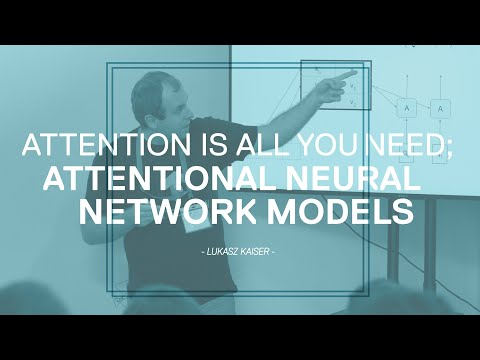

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('rBCqOTEfxvg')

# 4. A graph neural network

To express the Transformer model, some publications like to treat attention as **edges** (connections between nodes) in a graph, and adopt message passing on the edges to induce the appropriate processing.

When each word $s_i$ can attend to any other word $s_j$ (including self-loops), you get the following graph:

<br />
<left>
<img src="ipynb.images/source-self-attention.png" width=600 />
</left>

The target language graph is **half-complete**, in that $t_i$ attends to $t_j$ if $i>j$ (an output word cannot depend on future words because the the decoder loop is unidirectional).

<br />
<left>
<img src="ipynb.images/target-self-attention.png" width=600 />
</left>

>**Note**: I thought a bidirectional decoder would be a good research topic, because I do expect it may provide an additional advantage. In german for example, the verb is always at the end of the sentence, and depending on the verb, I may want to decline the subject (which precedes it) differently. And then I discovered that BERT *is* bidirectional!

The cross-language graph is a **bi-partitie graph**, where there is an edge from every source word $s_i$ to every target word $t_j$, meaning every target word can attend on source words.

<br />
<left>
<img src="ipynb.images/cross-attention.png" width=700 />
</left>

So the processing flow of Transformer is a 2-stage **message-passing** architecture within the complete graph:

- 1) Self-attention in encoder
- 2) Self-attention in decoder, followed by cross-attention between encoder and decoder

<br />
<left>
<img src="ipynb.images/full-transformer.png" width=700 />
</left>


### Preprocessing 
The Transfomer's preprocessing function `pre_func` first normalizes words representations, and then maps them to the set of queries, keys and values we talked about:

$$\begin{split}x \leftarrow \textrm{LayerNorm}(x) \\
[q, k, v] \leftarrow [W_q, W_k, W_v ]\cdot x\end{split}$$

### Postprocessing 
The postprocessing function `post_func` completes the whole computation corresponding to one layer of the transformer: 

- 1) Normalize $Z$ and get the output of Multi-Head Attention Layer $o$

$$\begin{split}\textrm{Z} \leftarrow \frac{\textrm{Z}}{z} \\
o \leftarrow W_o\cdot \textrm{Z} + b_o\end{split}$$

- 2) Apply a two layer position-wise feed forward layer on $x$, then add residual connection:

$$x \leftarrow x + \textrm{LayerNorm}(\textrm{FFN}(x))$$

where FFN refers to the feed forward function.

### A bit of code
The code below is from the `torch` attention library. Just to give you an idea. No need to study this *in depth*, we will continue to use  `tensorflow` for now.

```(python)
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def pre_func(self, i, fields='qkv'):
        layer = self.layers[i]
        def func(nodes):
            ...
        return func

    def post_func(self, i):
        layer = self.layers[i]
        def func(nodes):
            ...
        return func

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def pre_func(self, i, fields='qkv', l=0):
        layer = self.layers[i]
        def func(nodes):
            ...
        return func

    def post_func(self, i, l=0):
        layer = self.layers[i]
        def func(nodes):
            ...
        return func
```

For each node $i$ (no matter whether it is a source token or target word), you can decompose the attention computation into two steps:

- **Message computation**: Compute attention score `score`$_{ij}$ between $i$ and all nodes $j$ to be attended over, by taking the scaled-dot product between $q_i$ and $k_j$. The message sent from $j$ to $i$ will consist of the score `score`$_{ij}$ and the value $v_j$.
- **Message aggregation**: Aggregate the values $v_j$ from all $j$ according to scores `score`$_{ij}$.

This is how data is pre- and post-processed before and after the `propagate_attention()` functionove. Note: $wv$ = our $Z$ above.

```(python)
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, pos_enc, generator, h, d_k):
        super(Transformer, self).__init__()
        self.encoder, self.decoder = encoder, decoder
        self.src_embed, self.tgt_embed = src_embed, tgt_embed
        self.pos_enc = pos_enc
        self.generator = generator
        self.h, self.d_k = h, d_k

    def propagate_attention(self, g, eids):
        # Compute attention score
        g.apply_edges(src_dot_dst('k', 'q', 'score'), eids)
        g.apply_edges(scaled_exp('score', np.sqrt(self.d_k)))
        # Send weighted values to target nodes
        g.send_and_recv(eids,
                        [fn.src_mul_edge('v', 'score', 'v'), fn.copy_edge('score', 'score')],
                        [fn.sum('v', 'wv'), fn.sum('score', 'z')])
        
    def update_graph(self, g, eids, pre_pairs, post_pairs):
        "Update the node states and edge states of the graph."
        # Pre-compute queries and key-value pairs.
        for pre_func, nids in pre_pairs:
            g.apply_nodes(pre_func, nids)
        self.propagate_attention(g, eids)
        # Further calculation after attention mechanism
        for post_func, nids in post_pairs:
            g.apply_nodes(post_func, nids)

    def forward(self, graph):
        g = graph.g
        nids, eids = graph.nids, graph.eids

        # Word Embedding and Position Embedding
        src_embed, src_pos = self.src_embed(graph.src[0]), self.pos_enc(graph.src[1])
        tgt_embed, tgt_pos = self.tgt_embed(graph.tgt[0]), self.pos_enc(graph.tgt[1])
        g.nodes[nids['enc']].data['x'] = self.pos_enc.dropout(src_embed + src_pos)
        g.nodes[nids['dec']].data['x'] = self.pos_enc.dropout(tgt_embed + tgt_pos)

        for i in range(self.encoder.N):
            # Step 1: Encoder Self-attention
            pre_func = self.encoder.pre_func(i, 'qkv')
            post_func = self.encoder.post_func(i)
            nodes, edges = nids['enc'], eids['ee']
            self.update_graph(g, edges, [(pre_func, nodes)], [(post_func, nodes)])

        for i in range(self.decoder.N):
            # Step 2: Dncoder Self-attention
            pre_func = self.decoder.pre_func(i, 'qkv')
            post_func = self.decoder.post_func(i)
            nodes, edges = nids['dec'], eids['dd']
            self.update_graph(g, edges, [(pre_func, nodes)], [(post_func, nodes)])
            
            # Step 3: Encoder-Decoder attention
            pre_q = self.decoder.pre_func(i, 'q', 1)
            pre_kv = self.decoder.pre_func(i, 'kv', 1)
            post_func = self.decoder.post_func(i, 1)
            nodes_e, nodes_d, edges = nids['enc'], nids['dec'], eids['ed']
            self.update_graph(g, edges, [(pre_q, nodes_d), (pre_kv, nodes_e)], [(post_func, nodes_d)])

        return self.generator(g.ndata['x'][nids['dec']])
```

## Attention matrix examples

In self-encoding attention, different heads learn different relations between word pairs, in the same way CNNs learn multi-resolution structure in an image. 

Here's an english-german example of self-encoder attention matrices:

<left>
<img src="ipynb.images/encoder-self-attention-c.png" width=600 />
</left>

In encoder-decoder cross-attention, most words in the target sequence attend on their related words in the source sequence:

<left>
<img src="ipynb.images/encoder-self-attention-c.png" width=600 />
</left>

In decoder self-attention. most words attend on their previous few words:

<left>
<img src="ipynb.images/decoder-self-attention-c.png" width=600 />
</left>

If you think this is *complicated*, Google recently introduced the [Universal Transformer](https://arxiv.org/pdf/1807.03819.pdf) to address the problem that vanilla Transformer is *not computationally universal enough*. It essentially introduced recurrence back into Transformer, after having taken it out from seq2seq with attention!

The basic idea of Universal Transformer is to repeatedly revise its representations of *all* words in the sequence with each recurrent step by applying a Transformer layer on the representations.

Compared to vanilla Transformer, Universal Transformer *shares weights among its layers*, and does not fix recurrence time (number of layers in Transformer).

[Here's](https://github.com/dmlc/dgl/tree/master/examples/pytorch/transformer) the reference for all this code.

# 5. Tensorflow Transformer

The tensorflow [transformer](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb) is more complicated than our seq2seq-with-Attention model!

But I think we may be ready to start coding it!

In [47]:
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#BUFFER_SIZE = 20000
#BATCH_SIZE = 64

In [42]:
train_dataset = dataset_train
val_dataset = dataset_val

In [44]:
zh_batch, en_batch = next(iter(val_dataset))
zh_batch, en_batch

(<tf.Tensor: shape=(64, 35), dtype=int32, numpy=
 array([[   1,   37,  460, ...,    0,    0,    0],
        [   1,    4,  541, ...,    0,    0,    0],
        [   1,   20,   21, ...,    0,    0,    0],
        ...,
        [   1,   30,   54, ...,    0,    0,    0],
        [   1,   55, 1793, ...,    0,    0,    0],
        [   1,    9,   59, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 29), dtype=int32, numpy=
 array([[ 1, 12,  4, ...,  0,  0,  0],
        [ 1,  3, 15, ...,  0,  0,  0],
        [ 1, 53, 42, ...,  0,  0,  0],
        ...,
        [ 1, 18, 51, ...,  0,  0,  0],
        [ 1, 40, 32, ...,  0,  0,  0],
        [ 1,  7,  8, ...,  0,  0,  0]], dtype=int32)>)

Before we describe the encoder and decoder, let's work out a few details.

## Now for the genius of positional encoding

<left>
<img src="ipynb.images/toon-einstein.png" width=200 />
</left>

**Order of words** are essential parts of any language. They define **grammar** and thus the actual **semantics** of a sentence. 

Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But embeddings do not encode the relative position of words in a sentence. However, that is not the responsibility of the embedding layer. It is the responsibility of the **recurrence** or **convolution** layer.

But the Transformer model doesn't contain any recurrence or convolution, so **positional encoding** needs to be added to give the model some information about the relative position of the words in the sentence. 

>**An example**: If the sequence is `I think therefore I am`, the output representation for the second `I` is not the same as the output representation for the first `I` because the hidden state that is inputted into these words are not the same: For the second `I`, the hidden state has passed though the words `I think therefore` while for the first `I` the hidden state is just initialized. RNN’s hidden state ensures that identical words that are in different positions in an input sequence will have distinct output representations. But the self-attention layer of a Transformer (without any positional representation) causes identical words at different positions to have the same output representation. If the input sequence `I think therefore I am` is passed through just one Transformer, although the two `I`s are located at different positions in the input sequence, the inputs for their respective output representations are identical because each `I` is compared against every other word in the sentence.

So, a positional encoding:
- Should output a unique encoding for each time-step (word’s position in a sentence)
- The distance between any two time-steps should be consistent across sentences with different lengths.
- The model should generalize to longer sentences without any efforts. Its values should be bounded.
- Must be deterministic.

One idea is to assign a number to each time-step linearly. That is, the first word is given `1`, the second word is given `2`, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training.

Let's look at the binary numbers we used in our additon notebooks:

$$
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  2: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}$$

Can you see the rate of change between different bits? The LSB bit alternates on ***every*** number, the second-lowest bit alternates every ***two*** numbers, and so on.

But using binary values would be a waste of space in the world of floats. So instead, let's use their float continous counterparts: **Sinusoidal functions**. Indeed, they are the equivalent to alternating bits. Moreover, By decreasing their frequencies, we can go from red bits to orange ones!

The formula for calculating positional encoding is:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

That positional encoding vector is just ***added*** to the embedding vector. 

Why added?

Only the first few dimensions of the whole embedding are used to store the information about positions (see example plot below). And since the embeddings in the Transfomer are trained from scratch,  parameters are probably set in a way that the semantics of words do not get stored in the first few dimensions to avoid interfering with positional encoding.

After adding positional encoding, in d-dimensional space, words will be closer to each other based on the *similarity of their meaning*, but also based on their *position in the sentence*.

But wait! Won't position information vanish out once it reaches the upper layers in the encoder and decoder? Glad you asked! We will see that the Transformer architecture is equipped with **residual connections**. Therefore, information from the input of the model (which contains the positional embeddings) can efficiently propagate to further layers where more complex interactions are handled.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [4]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

Here's an example of positional encoding  for a sentence with the maximum length of 50 in 512-dimensional positonal encoding. Each row represents the embedding vector:

In [9]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()

NameError: name 'tf' is not defined

The column vectors $e(t)$ encode the position $t$ in an input embedding sequence of length $n$, where $d_\text{model}$ is the dimension of the embedding: 

$$\begin{equation}e(t) = \boldsymbol{E}_{t,:} := \begin{bmatrix} 
\sin\left(\frac{t}{f_1}\right)\\ 
\cos\left(\frac{t}{f_1}\right)\\ 
\sin\left(\frac{t}{f_2}\right)\\ 
\cos\left(\frac{t}{f_2}\right)\\ 
\vdots\\ 
\sin\left(\frac{t}{f_{\frac{d_\text{model}}{2}}}\right)\\ 
\cos\left(\frac{t}{f_{\frac{d_\text{model}}{2}}}\right) 
\end{bmatrix}\,,\tag{1}\end{equation}$$

where

$$f_m = \frac{1}{\lambda_m} := 10000^{\frac{2m}{d_\text{model}}}\,.\tag{2}$$

A matrix $\boldsymbol{T}^{(k)}$ exists such that for any $k$ and $t$:

$$\boldsymbol{T}^{(k)}\boldsymbol{E}_{t,:}=\boldsymbol{E}_{t+k,:}\tag{3}$$

If you take that matrix to be:

$$\begin{equation}\boldsymbol{T}^{(k)} = \begin{bmatrix} 
\boldsymbol{\Phi}^{(k)}_1 & \boldsymbol{0} & \cdots & \boldsymbol{0} \\ 
\boldsymbol{0} & \boldsymbol{\Phi}^{(k)}_2 & \cdots & \boldsymbol{0} \\ 
\boldsymbol{0} & \boldsymbol{0} & \ddots & \boldsymbol{0} \\ 
\boldsymbol{0} & \boldsymbol{0} & \cdots & \boldsymbol{\Phi}^{(k)}_{\frac{d_\text{model}}{2}} 
\end{bmatrix}\,,\tag{4}\end{equation}$$

where:

$$\begin{equation}\boldsymbol{\Phi}^{(k)}_m = \begin{bmatrix} 
\cos(r_mk) & -\sin(r_mk) \\ 
\sin(r_mk) & \cos(r_mk) 
\end{bmatrix}^\intercal\,,\tag{5}\end{equation}$$

Then because:

$$
\begin{align} 
\sin \left( {\alpha + \beta } \right) &= \sin \alpha \cos \beta + \cos \alpha \sin \beta\tag{7a}\\ 
\cos \left( {\alpha + \beta } \right) &= \cos \alpha \cos \beta – \sin \alpha \sin \beta\tag{7b} 
\end{align}
$$

$r_m = \lambda_m$ and $\boldsymbol{T}^{(k)}$ is fully specified and depends solely on $m$, $d_\text{model}$, and $k$. The position within the sequence, $t$, is not a parameter. And so for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. And so the model can easily learn to attend to by relative positions.

Here is a quote from the original paper:

>**[excerpt]**: We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of PEpos.

## Masking pad tokens

We also need to mask all the pad tokens in our sequences. Do you remember the problem we had when we worked with a batch of sequences and had to keep processing `0` tokens (past the `<end>` sentinel) in the decoder loop (in fact, I had a bug in my code related to that)? 

We need to do a better job ensuring that our model does not treat padding as an input. So we use a mask to indicate where pad value `0` is present: Output a `1` at those locations, and a `0` otherwise.

In [50]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

Here's an example of a padding mask. Notice how there are `1`s where there are `0`s in the sequences:

In [52]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

A look-ahead mask is also used to mask future tokens in a sequence. In other words, that mask indicates which entries should not be used.

<left>
<img src="ipynb.images/look-ahead-mask.png" width=300 />
</left>

This means that to predict the third word, only the first and second word can be used. To predict the fourth word, only the first, second and the third word will be used, and so on.

Using the look-ahead mask yields more useful scores for the decoder:

<left>
<img src="ipynb.images/masked-scores.png" width=700 />
</left>

Once you take the softmax of the masked scores, the negative infinities get zeroed out, leaving zero attention scores for future tokens:

<left>
<img src="ipynb.images/masked-scores-example.png" width=700 />
</left>

In [53]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

Here's an example:

In [54]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights and which we described a bit above is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of the square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude, straining the softmax function where it has small gradients and resulting in a very harsh softmax. 

<left>
<img src="ipynb.images/scaled_attention.png" width=400 />
</left>

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and thus you get a gentler softmax (not driving to `0` or `1` as much).

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [55]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and irrelevant words are flushed out.

In [56]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

Here's an examples of queries given a key and value:

In [57]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [58]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [59]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [60]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


The self-attention mechanism directly models relationships between all words in a sentence, regardless of their respective position. In the sentence `I arrived at the bank after crossing the river`, to determine that the word `bank` refers to the shore of a river and not a financial institution, the Transformer can learn to immediately attend to the word `river` and make this decision in a single step. 

More specifically, to compute the next representation for a given word - `bank` for example - the Transformer compares it to ***every other word*** in the sentence. The result of these comparisons is an attention score for every other word in the sentence. These attention scores determine how much each of the other words should contribute to the next representation of `bank`. In the example, the disambiguating `river` could receive a high attention score when computing a new representation for `bank`. The attention scores are then used as weights for a weighted average of all words’ representations which is fed into a fully-connected network to generate a new representation for `bank`, reflecting that the sentence is talking about a river bank.

This is the process:
- Embeddings go through dense layers to create q,k,v.
- Query and key are used to compute scores

<left>
<img src="ipynb.images/qkv.gif" width=450 />
</left>
<br/>

- This is what scores may look like for the sentence `hi how are you`:
<left>
<img src="ipynb.images/self-attention-example.png" width=400 />
</left>
<br />

- Following a softmax activation:
<left>
<img src="ipynb.images/softmax-self-attention-example.png" width=400 />
</left>
<br />

- The output of the self-attention layer is then fed though the next encoder or decoder:
<left>
<img src="ipynb.images/self-attention-output.png" width=700 />
</left>

## Multi-head attention

Instead of a single attention head, Q, K, and V are split into multiple heads because that allows the model to jointly attend to information at different positions from different representational spaces. 

So Multi-head attention consists of four parts:
*    Linear layers split into 8 heads
*    8 Scaled dot-product attentions
*    Concatenation of heads
*    Final linear layer

<left>
<img src="ipynb.images/multi_head_attention.png" width=400 />
</left>

After the split, each head has a reduced dimensionality so the total computation cost is the same as a single head attention with full dimensionality.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (`broadcast`ed for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer:

In [62]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [63]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Pointwise feed forward network

A pointwise feed forward network consists of two fully-connected layers with a ReLU activation in between:

In [64]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [65]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

Now we're ready to talk about the encoder and decoder. In that, the transformer model follows the same general pattern as our standard sequence to sequence with attention model, albeit with multiple layers:

* The input sentence is passed through `N` encoder layers that generate an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. Pointwise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [67]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

Here's an example:

In [68]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask): V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3. Pointwise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [69]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

Here's an example:

In [70]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

And now we can talk about the encoder.

The `Encoder` consists of:
1.   Word2vec semantic embedding
2.   Positional Encoding
3.   N encoder layers

The input is fed through an embedding which is then summed with  positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [71]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## The decoder

 The `Decoder` consists of:
1.   Word2vec embedding of the target sequence
2.   Positional Encoding
3.   N decoder layers

The target sequence is fed through an embedding and summed with positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to our final linear layer, which we mention in the wrapper Transformer layer.

In [73]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [74]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and our final affine (linear) `Dense` layer. The output of the decoder is the input to the linear layer and its output is returned.

In [75]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [76]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Hyperparameters

To keep this notebook small and relatively fast,  values for `num_layers`, `d_model`, and `dff` have been reduced. 

The values used in the base model of transformer are: `num_layers = 6`, `d_model = 512`, and `dff = 2048`. See [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

>**Note**: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [77]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

#input_vocab_size = tokenizer_pt.vocab_size + 2
#target_vocab_size = tokenizer_en.vocab_size + 2
input_vocab_size = len(inp_lang.word_index) + 1
target_vocab_size = len(targ_lang.word_index) + 1
dropout_rate = 0.1

In [78]:
len(input_tensor_train), input_vocab_size

(19865, 7485)

In [79]:
len(target_tensor_train), target_vocab_size

(19865, 10717)

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

We also used a learning in our CTC speech notebook.

In [80]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [81]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5,0,'Train Step')

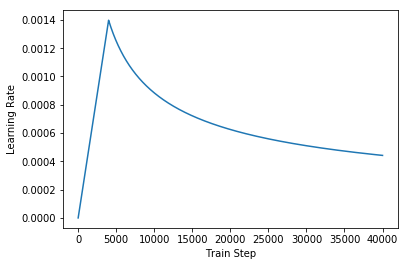

In [82]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [83]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [84]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [85]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [86]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [87]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

Create the `transformer` folder in your `~/data/training_checkpoints` folder.

In [88]:
checkpoint_path = "data/training_checkpoints/transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

The target is divided into `tar_inp` and `tar_real`. `tar_inp` is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "<start> A lion in the jungle is sleeping <end>"

`tar_inp` =  `<start> A lion in the jungle is sleeping`

`tar_real` = `A lion in the jungle is sleeping <end>`

The transformer is an auto-regressive model: it makes predictions one word at a time, and uses its output so far to decide what word to predict next. 

During training, this example uses teacher-forcing 

(as in the [text generation tutorial](./text_generation.ipynb)). 

Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, **self-attention** allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output, the model uses a look-ahead mask.

This is our training step:

In [90]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# for bigger corpuses
#train_step_signature = [
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#]

# for our corpus
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

And this is our training loop:

### Before you run this, run the cells below, which define the translation routine
We'll be running translations inline as we're training the transformer.

In [97]:
EPOCHS = 20

In [102]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
    # try a translation to see where we at
    try:
        translate(None, plot=True)
    except Exception:
        continue

Epoch 1 Batch 0 Loss 0.0940 Accuracy 0.2383
Epoch 1 Batch 50 Loss 0.1172 Accuracy 0.2333
Epoch 1 Batch 100 Loss 0.1287 Accuracy 0.2326
Epoch 1 Batch 150 Loss 0.1405 Accuracy 0.2315
Epoch 1 Batch 200 Loss 0.1551 Accuracy 0.2311
Epoch 1 Batch 250 Loss 0.1722 Accuracy 0.2307
Epoch 1 Batch 300 Loss 0.1921 Accuracy 0.2300
Epoch 1 Loss 0.1962 Accuracy 0.2299
Time taken for 1 epoch: 160.19409584999084 secs

<start> there was a big fire last night <end>
[[1, 49, 21, 7, 256, 354, 92, 164, 2]]
Epoch 2 Batch 0 Loss 0.1102 Accuracy 0.2277
Epoch 2 Batch 50 Loss 0.1272 Accuracy 0.2348
Epoch 2 Batch 100 Loss 0.1330 Accuracy 0.2331
Epoch 2 Batch 150 Loss 0.1433 Accuracy 0.2323
Epoch 2 Batch 200 Loss 0.1570 Accuracy 0.2313
Epoch 2 Batch 250 Loss 0.1722 Accuracy 0.2310
Epoch 2 Batch 300 Loss 0.1906 Accuracy 0.2303
Epoch 2 Loss 0.1946 Accuracy 0.2301
Time taken for 1 epoch: 161.558207988739 secs

<start> i dont care a bit about the future <end>
[[1, 4, 24, 320, 7, 516, 63, 3, 1040, 2]]
Epoch 3 Batch 0 Lo

## Model evaluation

The following steps are used for evaluation:

* Encode the input sentence using our chinese tokenizer (`tokenizer_zh`). Moreover, add the start and end sentinel tokens so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the original Transformer paper, use the entire dataset and base transformer model or transformer XL, by changing our hyperparameters above.

In [145]:
def evaluate(inp_sentence):
    #start_token = [tokenizer_pt.vocab_size]
    #end_token = [tokenizer_pt.vocab_size + 1]

    #inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    #inp_sentence = [targ_lang.word_index['<start>']]
    #inp_sentence.extend(inp_sentence)
    #inp_sentence.append(targ_lang.word_index['<end>'])
    inp_sentence = [targ_lang.word_index['<start>']] + inp_sentence[0] + [targ_lang.word_index['<end>']]
    print(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    #decoder_input = [tokenizer_en.vocab_size]
    decoder_input = [targ_lang.word_index['<start>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang.word_index['<end>']:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [205]:
import pinyin_jyutping_sentence
pinyin_jyutping_sentence.pinyin("我 喜欢 中国 菜")

'wǒ   xǐhuān   zhōngguó   cài'

In [227]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    #sentence = tokenizer_pt.encode(sentence)
    sentence = inp_lang.texts_to_sequences([sentence])

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        #ax.set_xticklabels(
        #    ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        #    fontdict=fontdict, rotation=90)
        #ax.set_xticklabels(
        #    ['<start>'] + [inp_lang.sequences_to_texts([i]) for i in sentence] + ['<end>'], 
        #    fontdict=fontdict, rotation=90)
        xticks = ['<start>']
        words = [inp_lang.sequences_to_texts([i]) for i in sentence]
        xticks.extend(words[0][0].split(' '))
        xticks.append('<end>')
        print('xticks:',xticks)
        ax.set_xticklabels(
            xticks, 
            fontdict=fontdict, rotation=90)


        print(result.numpy())
        twords = [targ_lang.sequences_to_texts([result.numpy()])]
        print(twords)
        twords = twords[0][0].split(' ')
        pwords = pinyin_jyutping_sentence.pinyin(' '.join(twords[1:]))
        print(pwords)
        yticks = [] #['<start>']
        yticks.extend(pwords.split(' '))
        yticks = [t for t in yticks if t]
        print('yticks:',yticks)
        #ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
        #                    if i < tokenizer_en.vocab_size], 
        #                   fontdict=fontdict)
        #ax.set_yticklabels([targ_lang.sequences_to_texts([i]) for i in result 
        #                    if i < targ_lang.num_words], 
        #                   fontdict=fontdict)
        ax.set_yticklabels(yticks, 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()

In [183]:
sentence = inp_lang.texts_to_sequences(["i will go there"])
xticks = ['<start>']
words = [inp_lang.sequences_to_texts([i]) for i in sentence]
xticks.extend(words[0][0].split(' '))
xticks.append('<end>')
xticks

['<start>', 'i', 'will', 'go', 'there', '<end>']

In [95]:
sentence = en[np.random.choice(len(en))]
print(sentence)
sentence_seq = inp_lang.texts_to_sequences([sentence])
print(sentence_seq)

<start> what is the ultimate purpose of education? <end>
[[1, 30, 8, 3, 6558, 1103, 12, 6559, 2]]


In [146]:
def translate(sentence=None, plot=''):
    if sentence is None:
        sentence = en[np.random.choice(len(en))]
    print(sentence)
    sentence_seq = inp_lang.texts_to_sequences([sentence])
    print(sentence_seq)
    
    result, attention_weights = evaluate(sentence_seq)
    print(result.numpy())

    #predicted_sentence = tokenizer_en.decode([i for i in result 
    #                                        if i < tokenizer_en.vocab_size])  
    predicted_sentence = targ_lang.sequences_to_texts([result.numpy()])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [135]:
[targ_lang.word_index['<start>']] + [[16, 8, 7, 230, 27, 18, 5]][0] + [targ_lang.word_index['<end>']]

[1, 16, 8, 7, 230, 27, 18, 5, 2]

In [234]:
translate("This is a problem we have to solve.")

This is a problem we have to solve.
[[16, 8, 7, 230, 27, 18, 5]]
[1, 16, 8, 7, 230, 27, 18, 5, 2]
[  1 134  24  14  91   4  75]
Input: This is a problem we have to solve.
Predicted translation: ['<start> 这是 一个 我们 必须 的 问题']


That translates to `This is a question we must` (Zhè shì yīgè wǒmen bìxū de wèntí).

It looks like the last word is not being picked up. I must have an end of sequence bug in my code. Can you fix it?

For the time being, I'll just repeat the last word:

In [231]:
translate("This is a problem we have to solve solve.")

This is a problem we have to solve solve.
[[16, 8, 7, 230, 27, 18, 5, 803]]
[1, 16, 8, 7, 230, 27, 18, 5, 803, 2]
[  1 134  24  14  91 348   4  75]
Input: This is a problem we have to solve solve.
Predicted translation: ['<start> 这是 一个 我们 必须 解决 的 问题']


That translates correcly! `This is a problem we must solve`, `这是 一个 我们 必须 解决 的 问题` (Zhè shì yīgè wǒmen bìxū jiějué de wèntí)

In [232]:
translate("I like watching tv after dinner dinner.")

I like watching tv after dinner dinner.
[[4, 32, 480, 356, 162, 379]]
[1, 4, 32, 480, 356, 162, 379, 2]
[  1   3  26   8 567 418]
Input: I like watching tv after dinner dinner.
Predicted translation: ['<start> 我 喜欢 在 晚餐 看电视']


That translates to `I like watching TV at dinner` (Wǒ xǐhuān zài wǎncān kàn diànshì).

In [233]:
translate("I like watching tv after i wake up wake up.")

I like watching tv after i wake up wake up.
[[4, 32, 480, 356, 162, 4, 744, 56, 744]]
[1, 4, 32, 480, 356, 162, 4, 744, 56, 744, 2]
[  1   3  26   8 418 154 921]
Input: I like watching tv after i wake up wake up.
Predicted translation: ['<start> 我 喜欢 在 看电视 后 洗澡']


That translates to `I like to take a shower after watching TV` (Wǒ xǐhuān zài kàn diànshì hòu xǐzǎo).

In [230]:
translate("I will go running tomorrow night.")
print ("Real translation: 我 明天 晚上 要 去 散步.")

I will go running tomorrow night.
[[4, 40, 39, 673, 129]]
[1, 4, 40, 39, 673, 129, 2]
[  1   3  83  38  19 395]
Input: I will go running tomorrow night.
Predicted translation: ['<start> 我 明天 要 去 散步']
Real translation: 我 明天 晚上 要 去 散步.


You can pass different layers and attention blocks of the decoder to the `plot` parameter in order to plot attention heads:

I will go running tomorrow night.
[[4, 40, 39, 673, 129]]
[1, 4, 40, 39, 673, 129, 2]
[  1   3  83  38  19 395]
Input: I will go running tomorrow night.
Predicted translation: ['<start> 我 明天 要 去 散步']
xticks: ['<start>', 'i', 'will', 'go', 'running', 'tomorrow', '<end>']
[  1   3  83  38  19 395]
[['<start> 我 明天 要 去 散步']]
wǒ   míngtiān   yào   qù   sànbù
yticks: ['wǒ', 'míngtiān', 'yào', 'qù', 'sànbù']
xticks: ['<start>', 'i', 'will', 'go', 'running', 'tomorrow', '<end>']
[  1   3  83  38  19 395]
[['<start> 我 明天 要 去 散步']]
wǒ   míngtiān   yào   qù   sànbù
yticks: ['wǒ', 'míngtiān', 'yào', 'qù', 'sànbù']
xticks: ['<start>', 'i', 'will', 'go', 'running', 'tomorrow', '<end>']
[  1   3  83  38  19 395]
[['<start> 我 明天 要 去 散步']]
wǒ   míngtiān   yào   qù   sànbù
yticks: ['wǒ', 'míngtiān', 'yào', 'qù', 'sànbù']
xticks: ['<start>', 'i', 'will', 'go', 'running', 'tomorrow', '<end>']
[  1   3  83  38  19 395]
[['<start> 我 明天 要 去 散步']]
wǒ   míngtiān   yào   qù   sànbù
yticks: ['wǒ', 'míngtiān', 'y

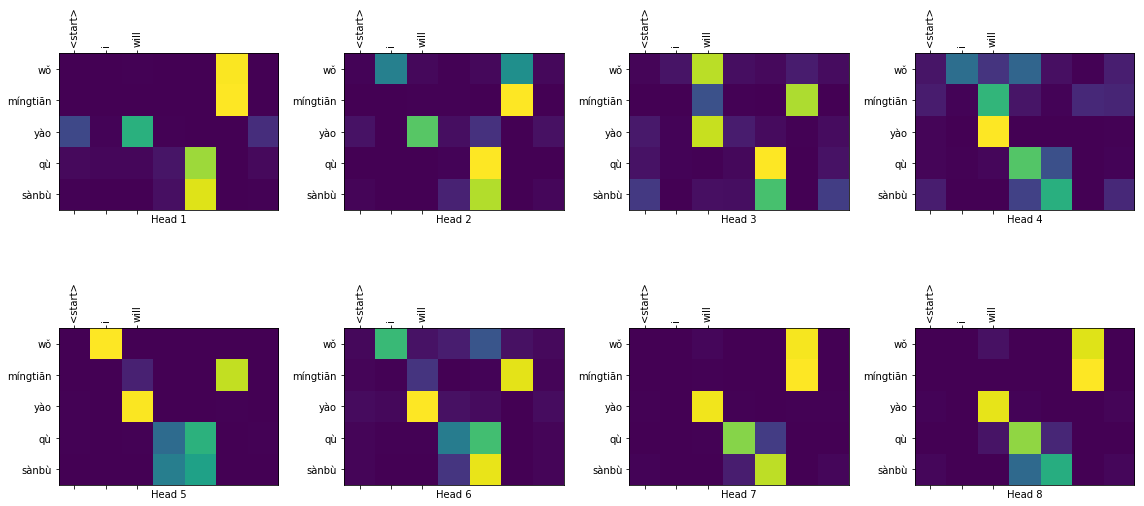

In [228]:
translate("I will go running tomorrow night.", plot='decoder_layer4_block2')
print ("Real translation: 我 明天 晚上 要 去 散步.")

In [235]:
transformer.save_weights("data/training_checkpoints/transformer/transformer100")

# Conclusion

We learned how to create a **transformer**, the state-of-the-art-model in NLP! 

After 100 epochs, which were also faster than seq2seq with attention, the translations are markedly better than seq2seq with attention.

# Research/Homework
- Train the model from scratch for 100 epochs and compare with seq2seq with attention. No GPU for now.
- If you're not able to, next week I will give you my saved weights to restore and translate sentences.
- Fix my last-word-of-the-sentence bug
- Try using a different dataset to train the transformer
- Create the full base transformer or transformer XL by changing the hyperparameters above, and maybe train for more epochs
- Use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models
- Implement **beam search** to get better predictions.

# Appendix: TFDS processing

Many of the datasets that researchers work on in NLP can be found [here](https://www.tensorflow.org/datasets/catalog/overview). However, these datasets are in a special format that requires its own "*special processing*". Here it is. I modified it to work with the 1.x version of tf, but will probably work for 2.x, too.
```(python)
pip install tensorflow_datasets
```

You should run the cell below at the very beginning of your notebook. Also note that eager execution is not required for tf 2.x.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
tf.enable_eager_execution()

import time
import numpy as np
import matplotlib.pyplot as plt

This errored out for me, but it informs you which datasets are available as a result:

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

```(python)
DatasetNotFoundError: Dataset ted_hrlr_translate not found. Available datasets:
	- bair_robot_pushing_small
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- cifar10
	- cifar100
	- coco2014
	- diabetic_retinopathy_detection
	- dummy_dataset_shared_generator
	- dummy_mnist
	- fashion_mnist
	- image_label_folder
	- imagenet2012
	- imdb_reviews
	- lm1b
	- lsun
	- mnist
	- moving_mnist
	- nsynth
	- omniglot
	- open_images_v4
	- quickdraw_bitmap
	- squad
	- starcraft_video
	- svhn_cropped
	- tf_flowers
	- wmt_translate_ende
	- wmt_translate_enfr
Check that:
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - dataset class is not in development, i.e. if IN_DEVELOPMENT=True
    - the module defining the dataset class is imported
```
And the error dump allowed me to find and download the english-to-french parallel dataset. This will take about 20 minutes to download:

In [ ]:
examples, metadata = tfds.load('wmt_translate_enfr', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Create a custom subwords tokenizer from the training dataset, using `tfds`:

In [ ]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary. That's a bit strange, but it is the state of the art of tokenization in NLP.

In [ ]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

```(python)
5299 ----> Tra
629 ----> ns
2152 ----> forme
42 ----> r 
484 ----> is 
7991 ----> a
1507 ----> we
1248 ----> so
460 ----> me
7940 ----> .
```

Buffer and batch parameters:

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [ ]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [ ]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [ ]:
To keep this example small and relatively fast, drop examples with a length of over 40 tokens:

MAX_LENGTH = 40

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

This is just to tell you the shape of our training dataset, we'll need that for a named paramter a few cells down:

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset

```(python)
<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.int64, tf.int64)>
```

Below is the original google notebook code, but it does not work because it's missing the required named parameter `padded_shapes`. I read on a blog that google fixed this in tf 2.2.

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

Run this instead:

(I got the `((None,),(None,))` from `((?,), (?,))` above)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes = ((None,),(None,)))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE, padded_shapes = ((None,),(None,)))

Now this should output batches of tokenized sentences in both languages:

pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

```(python)
(<tf.Tensor: id=6056420, shape=(64, 39), dtype=int64, numpy=
 array([[8215,  186,   50, ...,    0,    0,    0],
        [8215,  313,   69, ...,    0,    0,    0],
        [8215,  181,   17, ...,    0,    0,    0],
        ...,
        [8215, 5623, 7991, ...,    0,    0,    0],
        [8215,   99,  201, ...,    0,    0,    0],
        [8215,   68,   97, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: id=6056421, shape=(64, 40), dtype=int64, numpy=
 array([[8150,  963, 1734, ...,    0,    0,    0],
        [8150,  149,   11, ...,    0,    0,    0],
        [8150,  797,   57, ...,    0,    0,    0],
        ...,
        [8150, 7959, 1453, ...,    0,    0,    0],
        [8150,  102,    3, ...,    0,    0,    0],
        [8150,   77,    7, ...,    0,    0,    0]], dtype=int64)>)
 ```

In [ ]:
for (batch, (inp, tar)) in enumerate(train_dataset):
    print(inp, tar)
    break

```(python)
tf.Tensor(
[[8215   62 5941 ...    0    0    0]
 [8215   46   32 ...    0    0    0]
 [8215 3472  377 ...    0    0    0]
 ...
 [8215  150   24 ...    0    0    0]
 [8215   35   43 ...    0    0    0]
 [8215   11  105 ...    0    0    0]], shape=(64, 36), dtype=int64) tf.Tensor(
[[8150  373  609 ...    0    0    0]
 [8150  178 8004 ...    0    0    0]
 [8150 1800    7 ...    0    0    0]
 ...
 [8150   44 7337 ...    0    0    0]
 [8150   44  646 ...    0    0    0]
 [8150   64    5 ...    0    0    0]], shape=(64, 40), dtype=int64)
```

And the rest should be pretty similar to our own dataset!